<a href="https://colab.research.google.com/github/audwls4545/metaverse/blob/main/pytorch_lenet_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,),(1.0,))
    ]
)

train_data = datasets.MNIST(root='./',train=True,download=True,transform=data_transform)
test_data = datasets.MNIST(root='./',train=False,download=True,transform=data_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 73240257.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72754170.46it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22837914.30it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12322463.63it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32)
#loader를 통과할때 transforms.Compose에 세팅된 값이 적용됨

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self,x):
        x = self.conv1(x)
        x = F.tanh(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv2(x)
        x = F.tanh(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = F.tanh(x)
        x = x.view(-1,120)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        return x

model = Net()
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
image = torch.randn((1,1,32,32))
model(image)

tensor([[-0.0612, -0.0285,  0.0416, -0.1109, -0.0242,  0.0848,  0.0084, -0.1559,
          0.0339, -0.0214]], grad_fn=<TanhBackward0>)

In [6]:
x_train, y_train = train_data.data, train_data.targets
x_test,y_test = test_data.data, test_data.targets

x_train.shape

torch.Size([60000, 28, 28])

In [7]:
x_train = x_train.unsqueeze(1)
x_train.shape

torch.Size([60000, 1, 28, 28])

In [8]:
x_test = x_test.unsqueeze(1)
x_test.shape

torch.Size([10000, 1, 28, 28])

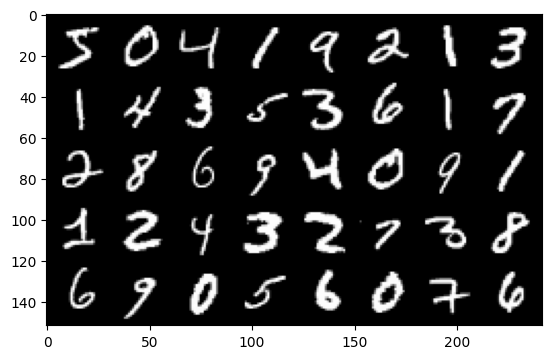

In [9]:
import matplotlib.pyplot as plt
from torchvision import utils
def show(img):
    temp_img = img.numpy()
    temp_img_tr = temp_img.transpose((1,2,0))
    plt.imshow(temp_img_tr,cmap='gray')

image_grid = utils.make_grid(x_train[:40],nrow=8,padding=2)
show(image_grid)

In [10]:
data,label = next(iter(train_loader))
print(data.shape)
print(label.shape)

torch.Size([32, 1, 32, 32])
torch.Size([32])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

from torchsummary import summary
summary(model, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [12]:
optim = Adam(model.parameters(),lr=1e-3)

for epoch in range(10):
    for data,label in train_loader:
        optim.zero_grad()
        pred = model(data.to(device))
        loss = nn.CrossEntropyLoss() (pred,label.to(device))
        loss.backward()
        optim.step()

    print(f'{epoch+1} loss:{loss.item()}')

1 loss:0.8260288834571838
2 loss:0.8245876431465149
3 loss:0.8066161274909973
4 loss:0.8170415759086609
5 loss:0.7978368997573853
6 loss:0.8682292103767395
7 loss:0.8087782859802246
8 loss:0.8813048005104065
9 loss:0.7970160841941833
10 loss:0.7977741956710815


In [13]:
model.eval()
with torch.no_grad():
    total_corr = 0

    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data,1)
        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr/len(test_data.targets)}')


Acc 0.9878


In [27]:
####images를 확인해서 어떤 방식으로 가공을 해야하나 알아봐야함
images.shape

torch.Size([16, 1, 32, 32])

In [14]:
# test_data.data[500]를 전처리해보기
test_data.data[500].size()

torch.Size([28, 28])

In [30]:
test_data.data[500]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  44,  47,  28, 116, 153, 254, 255,
         195, 115,  42,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  67, 121, 24

In [34]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,),(1.0,))
    ]
)

#내가 원하는 전처리하고 싶은 이미지 적용하기
#test_data.data[500]의 형태가 tensor로 되어있기 때문에 transforms.Compose에서 transforms.ToTensor()를 지우거나
#test_data.data[500].numpy()로해서 기본 형태를 numpy로 바꿔주면 변경가능
img = data_transform(test_data.data[500].numpy())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [35]:
img.size()

torch.Size([1, 32, 32])

In [36]:
#전처리를 했으니 모델에 적용해보기
#unsqueeze로 차원을 맞춰주고 to(device)를 통해서 지금 모델이 위치한 CPU or GPU에 얹어서 실행해야함
model(img.unsqueeze(0).to(device))

tensor([[-1.0000, -0.9999, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -1.0000]], grad_fn=<TanhBackward0>)

In [43]:
###실제 이미지로 활용해보기
from PIL import Image
img = Image.open('4.jpg') #jpg니까 3채널이라서 변경이 필요
img.size

(265, 257)

In [47]:
infer_transform = transforms.Compose(
    [
        transforms.ToTensor(), #다른 형식을 tensor로 만들기
        transforms.Grayscale(num_output_channels=1), #그레이 만들기
        transforms.Resize(32), # 사이즈 변경
        transforms.Normalize((0.5,),(1.0,)) #정규화
    ]
)

img = infer_transform(img)
img.size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 32, 32])

In [48]:
model(img.unsqueeze(0).to(device))

tensor([[-1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -0.9999,
         -1.0000, -1.0000]], grad_fn=<TanhBackward0>)

torch.Size([3, 257, 265])

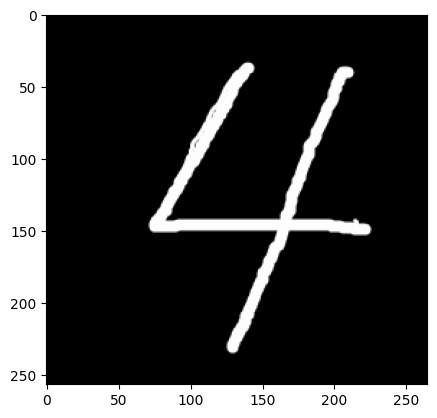

In [53]:
import torchvision

image = torchvision.io.read_image('/content/4.jpg')

show(image)
image.size()

In [57]:
infer2_transform = transforms.Compose(
    [
        #transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1), #그레이 만들기
        transforms.Resize(32), # 사이즈 변경
        #transforms.Normalize((0.5,),(1.0,)) #정규화
        #tensor가 되어있을때는 Normalize하면 안됨
    ]
)

image = infer2_transform(image)
image.size()

torch.Size([1, 32, 32])

In [58]:
model(image.unsqueeze(0).to(device))

RuntimeError: ignored

--------------------------------------여기까지 저번 복습끝-----------------------------

In [60]:
#학습을 시킬때 loss를 실시간 그래프로 확인하는 방법

In [59]:
%matplotlib inline
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
